This model is based on fastai 0.7 because thats what we get in kaggle, as soon as pytorch v1 is released and the kernels are updated I'll adjust for the changes I guess.
For now I only did standard stuff and used the new suggested learning rate methods of the 1 cycle learning policy as described here:
    
1. [blog post by Sylvain Gugger summarizing the following papers](https://sgugger.github.io/the-1cycle-policy.html#the-1cycle-policy)
2. [original papers by leslie smith on hyperparameter tuning](https://arxiv.org/pdf/1803.09820.pdf) 
3. [ and Superconvergence, the 1 cycle policy learning](https://arxiv.org/pdf/1708.07120.pdf)

Next things I planned would be to properly crop the images so it only includes the 32x32 sized patch that is the important part of the image, and check the augmentation settings.
I already set up some functionality to use hyperopt to optimiize the hyperparameters of the one cycle parameters, this will come in another kernel.
I also still need to check how many augmentation in the TTA  as used [here](https://towardsdatascience.com/augmentation-for-image-classification-24ffcbc38833)

I would also like check how the accuracy (or in this case ROC-AUC) changes with the different resnet18/34/50

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import os
from sklearn.metrics import roc_auc_score

from fastai import *
from fastai.vision import *
from torchvision.models import *

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL,space_eval,pyll
from hyperopt.pyll.stochastic import sample

%load_ext autoreload
%autoreload

Defining a metric so after epoch I get the validation ROC-AUC score

In [2]:
model_path='.'
path='../input/'
train_folder=f'{path}train'
test_folder=f'{path}test'
train_lbl=f'{path}train_labels.csv'
ORG_SIZE=96

bs=32
num_workers=None # Apprently 2 cpus per kaggle node, so 4 threads I think
sz=32

In Case I want to run quick tests use a subsample:

In [3]:
pd.read_csv(train_lbl)[:200*bs].set_index('id').to_csv('train_sub.csv')
train_lbl_sub='train_sub.csv'

In [4]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=1., max_zoom=.2,
                      max_lighting=0.05, max_warp=0.)
data = ImageDataBunch.from_csv(model_path,csv_labels=train_lbl_sub,folder='../input/train', ds_tfms=tfms, size=sz, suffix='.tif',bs=bs);
stats=[tensor([0.7215, 0.5673, 0.6832]), tensor([0.2385, 0.2768, 0.2233])] #data.batch_stats()
data=data.normalize(stats)

In [5]:
def get_im(idx):
    return open_image(data.items[idx])

## What do the augmentations look like?

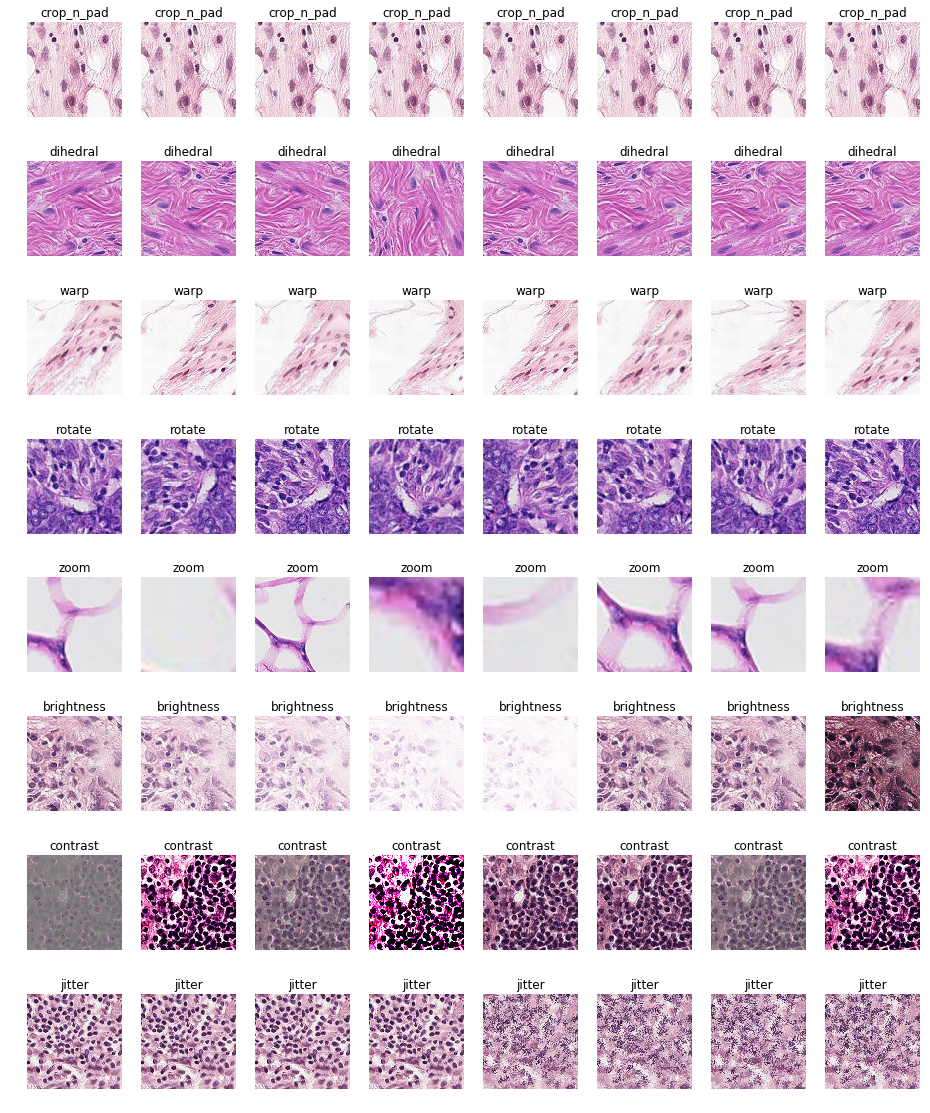

In [6]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=360., max_zoom=5.0,
                      max_lighting=.9, max_warp=0.5,xtra_tfms=jitter(magnitude=0.05,p=0.5))
tfms_name=['crop_n_pad','dihedral','warp','rotate','zoom','brightness','contrast','jitter']
_, axs = plt.subplots(8,8,figsize=(16,20))
idx=10
for i,title in enumerate(tfms_name):
    for j in range(axs.shape[1]):
        ax=axs[i,j]
        img = get_im(i+5).apply_tfms(tfms[0][i], get_im(i+5), size=96)
        img.show(ax=ax)
        ax.set_title(title)
del data

### Start training

In [7]:
def get_tfms_space(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75,jitter_p:float=0.75):
    tfms = get_transforms(do_flip=do_flip, flip_vert=flip_vert, max_rotate=max_rotate, max_zoom=max_zoom,
            max_lighting=max_lighting, max_warp=max_warp,xtra_tfms=jitter(magnitude=0.01,p=jitter_p))
    return tfms
space =     {'do_flip': hp.choice('do_flip', [True,False]),
            'flip_vert': hp.choice('flip_vert', [True,False]),
             'max_rotate': hp.quniform('max_rotate',0,180,5),
             'max_lighting': hp.uniform('max_lighting',0,0.5),
             'max_warp': hp.uniform('max_warp',0,0.75),
             'max_zoom': hp.uniform('max_zoom',1.0,1.5),
             'jitter_p': hp.uniform('jitter_p',0,0.75)
            }

In [8]:
def auc_score(y_pred,y_true,tens=True):
    score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    if tens:
        score=tensor(score)
    else:
        score=score
    return score

In [9]:
def f(space):
        
    tfms=get_tfms_space(**space)
    print(space)
    data_sample = ImageDataBunch.from_csv(path,csv_labels='../working/'+train_lbl_sub,folder='train', ds_tfms=tfms, size=sz, suffix='.tif',bs=bs,num_workers=0);
    stats=[tensor([0.7215, 0.5673, 0.6832]), tensor([0.2385, 0.2768, 0.2233])] #stats=data_sample.batch_stats()        
    data_sample.normalize(stats)
    learn = create_cnn(path='.',
                   data=data_sample,
                   arch=resnet34,
                   metrics=[auc_score]
                 )
    learn.fit_one_cycle(1,max_lr=3e-2)
    learn.unfreeze()
    learn.fit_one_cycle(1,max_lr=slice(5e-5,5e-4))
    x,y=learn.get_preds()
    score=auc_score(x,y,False)
    del learn
    del data_sample
    print(score)
    return -score

In [10]:
trials = Trials()

In [11]:
%time best = fmin(fn=f,    space=space,    algo=tpe.suggest,    trials=trials,    max_evals=50)

0.8668695984154925
{'do_flip': False, 'flip_vert': True, 'jitter_p': 0.5558948630369143, 'max_lighting': 0.1311048323227959, 'max_rotate': 40.0, 'max_warp': 0.35805357739028604, 'max_zoom': 1.4673424530341959}


epoch,train_loss,valid_loss,auc_score


In [12]:
print(trials)

In [13]:
trials.trials[0]['misc']['vals']

{'do_flip': [1],
 'flip_vert': [1],
 'jitter_p': [0.26510515150701625],
 'max_lighting': [0.4773505232203051],
 'max_rotate': [130.0],
 'max_warp': [0.7026116497354238],
 'max_zoom': [1.2182252034963204]}

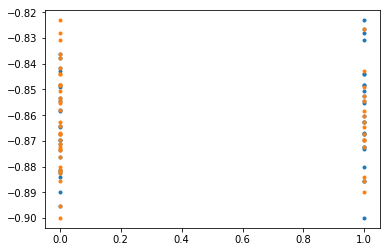

In [14]:
plt.plot([i['misc']['vals']['do_flip'] for i in trials.trials ],trials.losses(),'.')
plt.plot([i['misc']['vals']['flip_vert'] for i in trials.trials ],trials.losses(),'.')


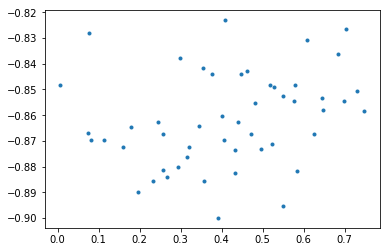

In [15]:
plt.plot([i['misc']['vals']['max_warp'] for i in trials.trials ],trials.losses(),'.')


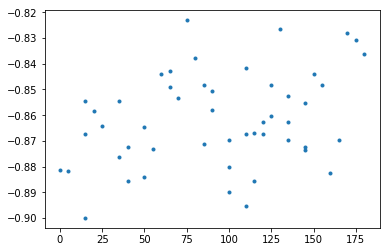

In [16]:
plt.plot([i['misc']['vals']['max_rotate'] for i in trials.trials ],trials.losses(),'.')


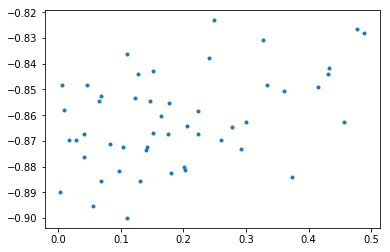

In [17]:
plt.plot([i['misc']['vals']['max_lighting'] for i in trials.trials ],trials.losses(),'.')


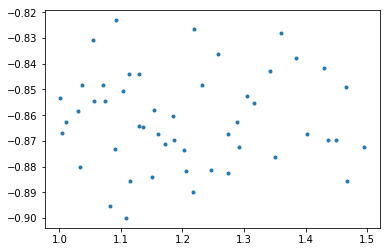

In [18]:
plt.plot([i['misc']['vals']['max_zoom'] for i in trials.trials ],trials.losses(),'.')


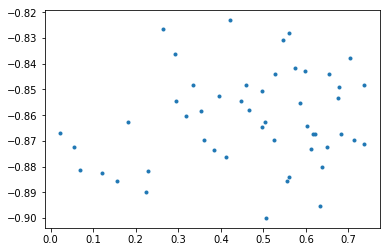

In [19]:
plt.plot([i['misc']['vals']['jitter_p'] for i in trials.trials ],trials.losses(),'.')


tfms=get_tfms_space(**best)

data_full = ImageDataBunch.from_csv(path,csv_labels=train_lbl,folder='train', ds_tfms=tfms, size=sz, suffix='.tif',test=test_folder,bs=bs,num_workers=0);
stats=data_full.batch_stats()        
data_full.normalize(stats)

learn = create_cnn(path='.',
                   data=data_full,
                   arch=resnet18,
                   metrics=[auc_score]
                 )
learn.lr_find()
learn.recorder.plot()


learn.fit_one_cycle(1,max_lr=3e-2)
learn.recorder.plot_losses()
learn.save('warmup')

learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

learn.fit_one_cycle(1,max_lr=slice(5e-5,5e-4))
learn.recorder.plot_losses()

### Warm up with frozen weight is done on a subset so we dont have to waste an entire epoch

Sometimes its important in which order the ids in the submissions are so to make sure I don't mess up I put them in the same order. My first submission had a 50% score so I somewhere messed up the order oder the matching of id to label.
since fname_clean is the id we can just use that as index when adding the correct label in our dataframe. 

learn.recorder.plot()

sub=pd.read_csv(f'{path}/sample_submission.csv').set_index('id')
sub.head()

pred_label_mean=np.mean(preds_test,axis=0)[:,0]

pred_label_max=np.max(preds_test,axis=0)[:,0]
pred_label_max

clean_fname=np.vectorize(lambda fname: fname.split('/')[3].split('.')[0])
fname_cleaned=clean_fname(data_full.test_ds.fnames)
fname_cleaned=fname_cleaned.astype(str)

## I add the score to the name of the file so I can later plot the leaderboard score versus my validation score
In the fastai course Jeremy mentions that if you have a monotonic relation between validation and LB score the way you set up your validation set matches what the test set consists of.

sub.loc[fname_cleaned,'label']=pred_label_mean
sub.to_csv(f'submission_mean_{mean_score}.csv')

sub.loc[fname_cleaned,'label']=pred_label_max
sub.to_csv(f'submission_max_{max_score}.csv')

### I stil need to remove folders because kaggle othwise complain s because I have too many subfolders